<div class="alert alert-success">
    <strong>[Plant Seeldlings Competition](https://www.kaggle.com/c/plant-seedlings-classification)</strong>
    <img src='imgs/PlantSeedling.png'/>
    
</div>

## Libraries

In [20]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
import splitfolders

import torch
import torch.nn as nn # neural network moudle
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

from imgaug import augmenters as iaa

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *
from data_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [21]:
use_gpu

False

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test


In [2]:


input_folder="dataset/plant-seedlings-classification/train/"
splitfolders.ratio(input_folder, output="plant-seedlings-classification\Splite_plant", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 4750 files [00:32, 146.85 files/s]


In [3]:
trn_dir = 'dataset/plant-seedlings-classification/train/'
val_dir = 'plant-seedlings-classification/Splite_plant/val'


In [22]:

sz = 224
batch_size = 16


In [23]:
os.listdir(trn_dir)

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [24]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.png')
trn_fnames[:5]

['dataset/plant-seedlings-classification/train\\Black-grass\\0050f38b3.png',
 'dataset/plant-seedlings-classification/train\\Black-grass\\0183fdf68.png',
 'dataset/plant-seedlings-classification/train\\Black-grass\\0260cffa8.png',
 'dataset/plant-seedlings-classification/train\\Black-grass\\05eedce4d.png',
 'dataset/plant-seedlings-classification/train\\Black-grass\\075d004bc.png']

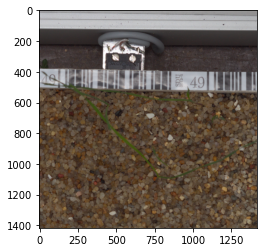

In [25]:
img = plt.imread(trn_fnames[15]) # covert to numpy array
plt.imshow(img); #show image

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [26]:
train_ds = datasets.ImageFolder(trn_dir) # we can add each component of transformation

In [27]:
train_ds.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [28]:
train_ds.class_to_idx

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [29]:
train_ds.root   #path in computer

'dataset/plant-seedlings-classification/train/'

In [13]:
# train_ds.imgs

In [14]:
# list(zip(*train_ds.imgs))

In [15]:
type(train_ds.transform)   #since we donot exeute any transformation

NoneType

### Transformations

Dataloader object uses these tranformations when loading data.

In [31]:
# Data augmentation and normalization just for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [32]:
train_ds = datasets.ImageFolder(trn_dir, train_transforms)
valid_ds = datasets.ImageFolder(val_dir, valid_transforms)

#### Dataloaders

In [33]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

In [34]:
train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes


Train size: 4750
Valid size: 947 (0.17)


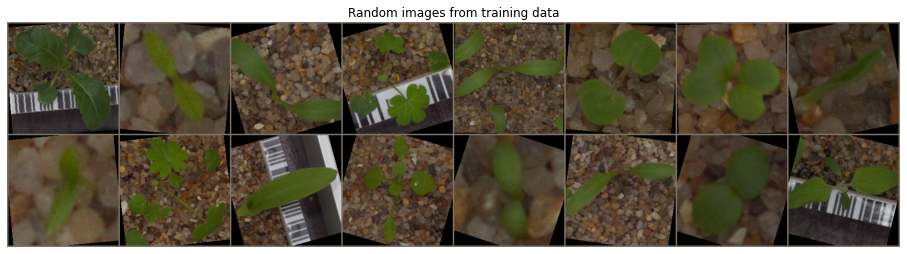

In [35]:
inputs, targets = next(iter(train_dl))  

out = torchvision.utils.make_grid(inputs, padding=3) # colect and put together like a grid
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data') #the number of picture =the bach size=32

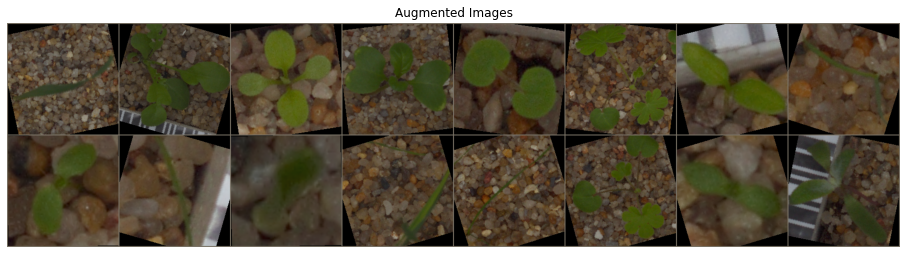

In [36]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images')

## Model: CNN

In [39]:
class SimpleCNN(nn.Module):
    
    def __init__(self):      # this is an object and conv1 and conv2 are attributes
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),   # CNN layer 3 : deep of picture  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2), #CNN layer
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 12)     # fully connected layer
        
    def forward(self, x):   # x: a picture or a batch of picture.  In this layer we do all computation
        out = self.conv1(x)               
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)  # like reshape
        out = self.fc(out)
        return out

Now, it's time to create the model and to put it on the GPU.

In [40]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [41]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=12, bias=True)
)

## Loss function and optimizer

## Train

In [42]:
# load pre-trained ResNet50
model = load_pretrained_resnet50(model_path=None, num_classes=12)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [43]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=5)

Epoch 1/5
----------
  train Loss: 0.69962 Acc: 0.76611
  valid Loss: 0.17033 Acc: 0.94298

Epoch 2/5
----------
  train Loss: 0.25208 Acc: 0.91558
  valid Loss: 0.11064 Acc: 0.95987

Epoch 3/5
----------
  train Loss: 0.16547 Acc: 0.94168
  valid Loss: 0.09553 Acc: 0.97677

Epoch 4/5
----------
  train Loss: 0.12080 Acc: 0.95726
  valid Loss: 0.08308 Acc: 0.97149

Epoch 5/5
----------
  train Loss: 0.10948 Acc: 0.96147
  valid Loss: 0.05809 Acc: 0.97782

Training complete in 518m 2s
Best val Acc: 0.9778


#### Accuracy on validation data

In [45]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [46]:
evaluate_model(model, valid_dl, device)

accuracy: 97.78


In [48]:
evaluate_model(model, train_dl, device)

accuracy: 98.06


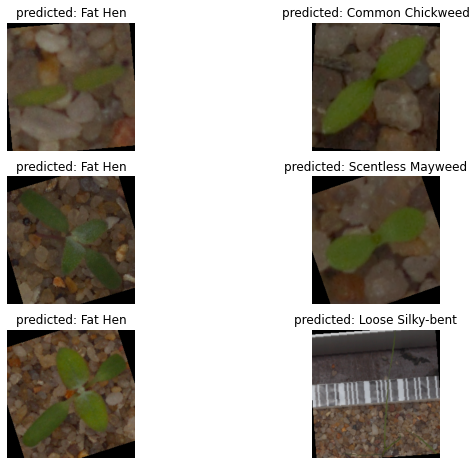

In [49]:
visualize_model(model, train_dl, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [05:29<00:00,  5.49s/it]


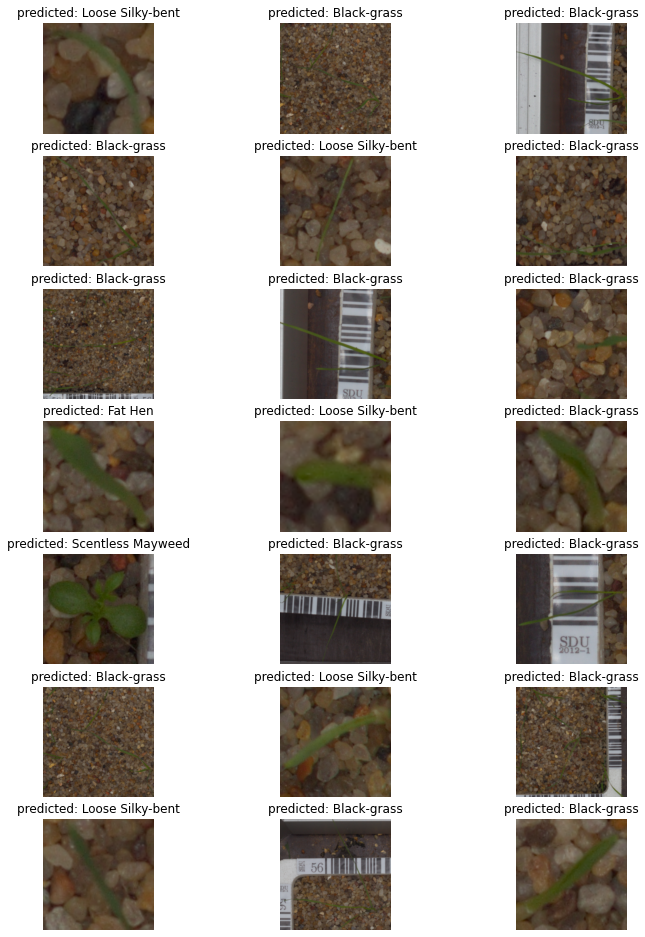

21 images out of 947 were misclassified.


In [50]:
plot_errors(model, valid_dl, device)

#### Confusion matrix

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [05:09<00:00,  5.17s/it]


[[0.94 0.   0.   0.   0.   0.   0.06 0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.02 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.05 0.   0.   0.   0.93 0.02 0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.09 0.   0.   0.   0.   0.   0.91 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.02 0.98 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.02 0.98 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


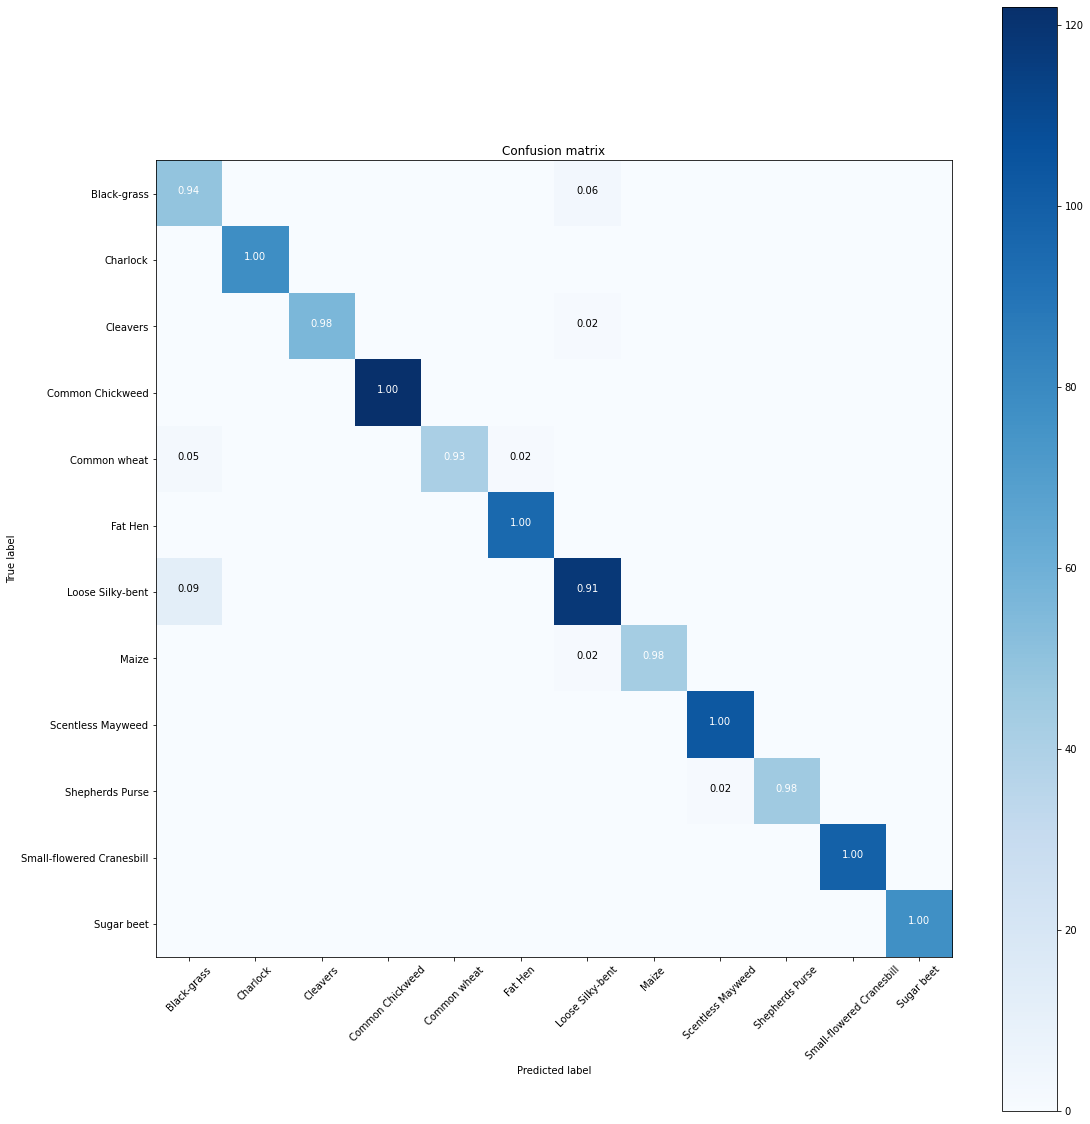

In [51]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(16, 16))